<a href="https://colab.research.google.com/github/Alf-caput/NFL2022_TacklePredictNN/blob/dev1/Practica_final_mejoras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NFL Big Data Bowl 2024

Kaggle lanza el concurso NFL Big Data Bowl 2024 sponsorizado por National Football League con un premio de $100,000.
https://www.kaggle.com/c/nfl-big-data-bowl-2024

## INTRODUCCIÓN

El fútbol americano es un deporte complejo donde la tarea principal de los defensores es derribar al portador del balón, mientras que este último busca avanzar en el campo. El siguiente proyecto tiene como objetivo crear métricas para valorar elementos clave en los placajes.

Se utiliza la información de las estadísticas Next Gen de la NFL, incluyendo datos de seguimiento de jugadores de las primeras nueve semanas de la temporada 2022. Estos datos abarcan la ubicación, velocidad y aceleración de los 22 jugadores en el campo, así como la posición del balón. Además, se incorporan datos de evaluación de jugadores de PFF y estadísticas avanzadas de la NFL, como puntos esperados y probabilidad de victoria.

La finalidad del proyecto es presentar los resultados a la NFL. Las métricas y análisis destacados podrían ser utilizados por los equipos de la NFL para evaluar a sus jugadores tanto en el ámbito ofensivo como defensivo.

## OBJETIVOS DEL CONCURSO

Se pide generar ideas prácticas, novedosas y ejecutables a partir de los datos de seguimiento de jugadores relacionados con los placajes. Algunos ejemplos incluyen, pero no se limitan a:

- Predicciones del tiempo, probabilidad y/o ubicación del derribo.
- Rango de derribo: ángulo de persecución, velocidad y aceleración, velocidad de cierre.
- Evaluación del jugador (por ejemplo, yardas salvadas, valor del derribo, derribos fallidos).
- Asignación de créditos (por ejemplo, un jugador realiza un derribo debido a otro jugador, bloqueos superados, área de influencia).
- Tipo de derribo (individual vs. en grupo, en campo abierto vs. en las trincheras, etc.).
- Roles y responsabilidades del equipo y los jugadores (marcar el límite, ocupar huecos, etc.).

Es importante destacar que la lista anterior no es exhaustiva y se anima a los participantes a ser creativos con sus propuestas.







# Descarga del dataset

Descargamos el dataset que ha sido previamente subido a google drive.

In [1]:
import gdown

id = '1V_fIjH-WGHTVgyRkdNFkZ6XxiqDoaMrA'
folder = 'nfl-big-data-bowl-2024'
endpoint = '.zip'

url = f'https://drive.google.com/uc?id={id}'

output = folder + endpoint

gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1V_fIjH-WGHTVgyRkdNFkZ6XxiqDoaMrA
To: /content/nfl-big-data-bowl-2024.zip
100%|██████████| 293M/293M [00:05<00:00, 55.7MB/s]


'nfl-big-data-bowl-2024.zip'

Descomprimimos la carpeta `nfl-big-data-bowl-2024.zip` que se ha descargado.

In [2]:
from zipfile import ZipFile

with ZipFile(output, 'r') as zObject:
	zObject.extractall(folder)

Creamos una lista que contiene cada archivo `.csv` de la carpeta ya descomprimida y la ordenamos.

In [3]:
import pandas as pd
import os

csv_files = [file for file in os.listdir(folder) if file.endswith('.csv')]
csv_files.sort()

Dentro de la carpeta `nfl-big-data-bowl-2024` se encuentran los csv que utilizaremos.

In [4]:
print(csv_files)

['games.csv', 'players.csv', 'plays.csv', 'tackles.csv', 'tracking_week_1.csv', 'tracking_week_2.csv', 'tracking_week_3.csv', 'tracking_week_4.csv', 'tracking_week_5.csv', 'tracking_week_6.csv', 'tracking_week_7.csv', 'tracking_week_8.csv', 'tracking_week_9.csv']


A continuación creamos un diccionario para facilitarnos el acceso a los diferentes dataframes (dfs).

In [31]:
if 'dfs' not in locals(): # Si ya se ha creado, no se volverá a crear
  dfs = {os.path.splitext(file)[0]: pd.read_csv(os.path.join(folder, file)) for file in csv_files}

En el diccionario, si especificamos la clave "`games`" obtenemos el contenido del csv.

# Estudio previo de los datos

Tenemos varios dataframes que vamos a analizar para ver qué enfoque dar a los datos de entrada y de salida de la red neuronal.

Nota: Ya que la cantidad de datos en cada tabla impresa es bastante grande, usamos `.head(3)` para mostrar solamente las 3 primeras filas.

- Resultados de partidos

In [6]:
dfs['games'].head(3) # para que muestre las 3 primeras filas

,gameId,season,week,gameDate,gameTimeEastern,homeTeamAbbr,visitorTeamAbbr,homeFinalScore,visitorFinalScore
0,2022090800,2022,1,09/08/2022,20:20:00,LA,BUF,10,31
1,2022091100,2022,1,09/11/2022,13:00:00,ATL,NO,26,27
2,2022091101,2022,1,09/11/2022,13:00:00,CAR,CLE,24,26


- Datos de seguimiento en la primera semana

In [7]:
dfs['tracking_week_1'].head(3)

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN


- Datos de las jugadas realizadas

In [8]:
dfs['plays'].head(3)

,gameId,playId,ballCarrierId,ballCarrierDisplayName,playDescription,quarter,down,yardsToGo,possessionTeam,defensiveTeam,...,preSnapHomeTeamWinProbability,preSnapVisitorTeamWinProbability,homeTeamWinProbabilityAdded,visitorTeamWinProbilityAdded,expectedPoints,expectedPointsAdded,foulName1,foulName2,foulNFLId1,foulNFLId2
0,2022100908,3537,48723,Parker Hesse,(7:52) (Shotgun) M.Mariota pass short middle t...,4,1,10,ATL,TB,...,0.976785,0.023215,-0.006110,0.006110,2.360609,0.981955,NaN,NaN,NaN,NaN
1,2022091103,3126,52457,Chase Claypool,(7:38) (Shotgun) C.Claypool right end to PIT 3...,4,1,10,PIT,CIN,...,0.160485,0.839515,-0.010865,0.010865,1.733344,-0.263424,NaN,NaN,NaN,NaN
2,2022091111,1148,42547,Darren Waller,(8:57) D.Carr pass short middle to D.Waller to...,2,2,5,LV,LAC,...,0.756661,0.243339,-0.037409,0.037409,1.312855,1.133666,NaN,NaN,NaN,NaN


Queremos crear una única tabla con los ids (`gameId`) y los datos de entrenamiento de la primera semana (`tracking_week_1`)

In [9]:
game_ids = dfs['tracking_week_1']['gameId'].unique()

In [10]:
df = dfs['tracking_week_1']
df[df['gameId'] == game_ids[0]].head(3) # mostramos las 3 primeras entradas del primer partido de la primera semana de entrenamiento

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
1,2022090800,56,35472.0,Rodger Saffold,2,2022-09-08 20:24:05.299999,76.0,BUF,left,88.47,27.13,1.67,0.61,0.17,230.98,148.53,pass_arrived
2,2022090800,56,35472.0,Rodger Saffold,3,2022-09-08 20:24:05.400000,76.0,BUF,left,88.56,27.01,1.57,0.49,0.15,230.98,147.05,NaN


El tipo de dato de `time`

In [11]:
print(type(dfs['tracking_week_1']['time'][0]))


<class 'str'>


Vamos a obtener un snapshot del primer juego en el primer instante de tiempo y lo vamos a graficar.

In [12]:
df = dfs['tracking_week_1']
snapshot = df[df['time'] == df['time'][0]]
snapshot.head(3)

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
22,2022090800,56,38577.0,Bobby Wagner,1,2022-09-08 20:24:05.200000,45.0,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN
44,2022090800,56,41239.0,Aaron Donald,1,2022-09-08 20:24:05.200000,99.0,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN


## Representación de los datos

Para graficar los jugadores en el campo en dicho instante de tiempo usaremos matplotlib.

In [13]:
!pip install matplotlib

Organizamos los distintos clubs.

In [14]:
clubs = snapshot['club'].unique()
clubs

array(['BUF', 'LA', 'football'], dtype=object)

El club 'football' es el del balón.

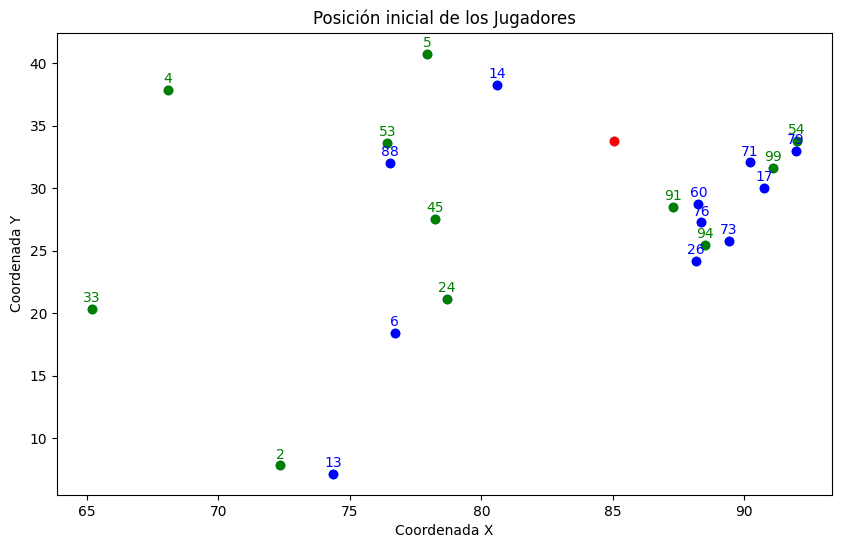

In [15]:
import matplotlib.pyplot as plt
import itertools

# Crear el gráfico de dispersión
plt.figure(figsize=(10, 6))
plt.scatter(snapshot['x'], snapshot['y'], marker='o')

# Añadir etiquetas y título
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Posición inicial de los Jugadores')


# Añadir etiquetas para cada punto
for i, row in snapshot.iterrows():
    if row['club'] == clubs[0]:
      color = 'blue'
    elif row['club'] == clubs[1]:
      color = 'green'
    else:
      color = 'red'
    if color != 'red':
      plt.annotate(int(row['jerseyNumber']), (row['x'], row['y']), textcoords="offset points", xytext=(0, 5), ha='center',color=color)
    plt.scatter(row['x'], row['y'],color=color)

# Mostrar el gráfico
plt.show()

Se muestra cada equipo en un color y el balón en rojo. Cada jugador tiene un número de jersey.

Pero lo que nos interesa es ver el ritmo del juego por lo que tomaremos como ejemplo la jugada 56 del primer partido, y representaremos sus frames.

In [16]:
play56_game1 = df[df['playId']==56][df['gameId']==2022090800]

<ipython-input-16-b2f1f145e5b4>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  play56_game1 = df[df['playId']==56][df['gameId']==2022090800]


Graficamos los 4 primeros frames de la jugada 56 del primer partido.

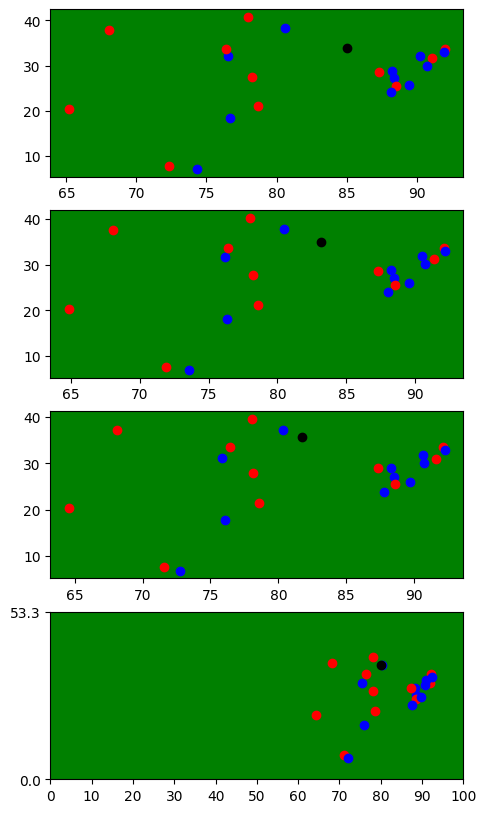

In [17]:
import matplotlib.pyplot as plt
frames = play56_game1['frameId'].unique() # contamos cuantos frames tiene la jugada 56
clubs = play56_game1['club'].unique()     # los equipos del partido (el balón es el equipo 'football')

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(5.33, 10))

for frame in df['frameId'].unique()[:4]:
  snapshot = play56_game1[play56_game1['frameId'] == frame]
  for i, row in snapshot.iterrows():
    if row['club'] == clubs[0]:
      color = 'blue'
    elif row['club'] == clubs[1]:
      color = 'red'
    else:
      color = 'black'
    axs[frame-1].scatter(row['x'], row['y'], marker='o', color=color)
    plt.xticks(range(0, 110, 10))
    plt.yticks([0, 53.3])
    axs[frame-1].set_facecolor('green')

plt.show()


Podríamos graficar todos los frames pero con 4 ya se ve cómo los jugadores y el balón se mueven por el campo.

Nota: el campo de juego del fútbol americano tiene 100 yardas de largo y 53.3 de ancho.

## Un ejemplo

Tomaremos un frame para ver en detalle sus características.

In [18]:
df = dfs['tracking_week_1']

game_ids = dfs['tracking_week_1']['gameId'].unique()    # IDs de los partidos
game_1 = df[df['gameId']==game_ids[0]]                  # Primer partido

play_ids = game_1['playId'].unique()                    # IDs de las jugadas en el partido 1
play1_game1 = game_1[game_1['playId']==play_ids[0]]     # Primera jugada

frame_ids = play1_game1['frameId'].unique()                                 # IDs de los frames de la jugada 1 del partido 1
play1_game1_frame1 = play1_game1[play1_game1['frameId']==frame_ids[0]]      # Primer frame

El primer partido tiene 91 jugadas

In [19]:
len(game_1['playId'].unique())

91

Y en la primera jugada hay 22 frames

In [20]:
len(frame_ids)

22

Este es el formato que tiene un frame.

In [21]:
play1_game1_frame1.head(3)

,gameId,playId,nflId,displayName,frameId,time,jerseyNumber,club,playDirection,x,y,s,a,dis,o,dir,event
0,2022090800,56,35472.0,Rodger Saffold,1,2022-09-08 20:24:05.200000,76.0,BUF,left,88.37,27.27,1.62,1.15,0.16,231.74,147.90,NaN
22,2022090800,56,38577.0,Bobby Wagner,1,2022-09-08 20:24:05.200000,45.0,LA,left,78.25,27.53,1.24,3.81,0.11,4.20,331.67,NaN
44,2022090800,56,41239.0,Aaron Donald,1,2022-09-08 20:24:05.200000,99.0,LA,left,91.08,31.61,3.91,2.34,0.40,168.33,132.02,NaN


# Preparación de los datos

La manera en la que vamos a usar los datos será en un vector, cada entrada consistirá en un frame de una jugada, y la red neuronal debe predecir qué jugador acabará con la posesión del balón al finalizar la jugada.

Concatenamos todos los datos de las semanas de entrenamiento 1-10 y eliminamos algunas columnas innecesarias para la predicción. A este dataframe lo llamamos `ds`.

In [32]:
ds = pd.concat([dfs[f'tracking_week_{i}'] for i in range(1, 10)])
ds.drop(columns=['displayName', 'jerseyNumber', 'event', 'time'], inplace=True)
ds

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis,o,dir
0,2022090800,56,35472.0,1,BUF,left,88.370000,27.270000,1.62,1.15,0.16,231.74,147.90
1,2022090800,56,35472.0,2,BUF,left,88.470000,27.130000,1.67,0.61,0.17,230.98,148.53
2,2022090800,56,35472.0,3,BUF,left,88.560000,27.010000,1.57,0.49,0.15,230.98,147.05
3,2022090800,56,35472.0,4,BUF,left,88.640000,26.900000,1.44,0.89,0.14,232.38,145.42
4,2022090800,56,35472.0,5,BUF,left,88.720000,26.800000,1.29,1.24,0.13,233.36,141.95
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150018,2022110700,3787,NaN,40,football,right,26.219999,19.680000,1.37,2.58,0.15,NaN,NaN
1150019,2022110700,3787,NaN,41,football,right,26.320000,19.610001,1.07,2.74,0.12,NaN,NaN
1150020,2022110700,3787,NaN,42,football,right,26.389999,19.559999,0.80,2.49,0.09,NaN,NaN
1150021,2022110700,3787,NaN,43,football,right,26.450001,19.520000,0.57,2.38,0.07,NaN,NaN


Ordenamos `ds`

In [33]:
ds.sort_values(by=['gameId', 'playId', 'frameId', 'club'], ascending=True, inplace=True)
ds.reset_index(drop=True, inplace=True)

## Dirección de la jugada

En vez de 'left' / 'right' usaremos 0 / 1.

In [34]:
ds['playDirection'] = ds['playDirection'].replace({'left': 0, 'right': 1})
ds

,gameId,playId,nflId,frameId,club,playDirection,x,y,s,a,dis,o,dir
0,2022090800,56,35472.0,1,BUF,0,88.37,27.27,1.62,1.15,0.16,231.74,147.90
1,2022090800,56,42392.0,1,BUF,0,88.25,28.74,0.67,1.97,0.07,244.21,30.29
2,2022090800,56,42489.0,1,BUF,0,80.60,38.29,6.23,0.90,0.62,140.05,189.38
3,2022090800,56,44875.0,1,BUF,0,89.42,25.81,1.89,2.47,0.18,242.67,65.25
4,2022090800,56,44985.0,1,BUF,0,76.70,18.39,4.79,6.34,0.49,157.83,233.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187393,2022110700,3787,52942.0,44,NO,1,20.01,24.78,0.71,0.74,0.07,150.01,224.36
12187394,2022110700,3787,53098.0,44,NO,1,31.32,35.89,4.83,2.53,0.49,121.62,155.20
12187395,2022110700,3787,54476.0,44,NO,1,29.35,9.76,0.30,1.01,0.04,39.41,104.09
12187396,2022110700,3787,55125.0,44,NO,1,23.91,20.89,1.27,1.05,0.13,121.53,124.84


### EQUIPO LOCAL/VISITANTE

Local/visitante aparece como `homeTeamAbbr`/`visitorTeamAbb`en el dataset de partidos. Y lo queremos añadir a `ds`.

In [35]:
ds = pd.merge(ds, dfs['games'][['homeTeamAbbr', 'gameId']], on='gameId', how='left')

Con valor 1 (local), -1 (visitante) y 0 (balón)

In [37]:
ds['local'] = -1
ds.loc[ds['club'] == ds['homeTeamAbbr'], 'local'] = 1
ds.loc[ds['club'] == 'football', 'local'] = 0
ds.drop(columns=['club', 'homeTeamAbbr'], inplace=True)
ds

,gameId,playId,nflId,frameId,playDirection,x,y,s,a,dis,o,dir,local
0,2022090800,56,35472.0,1,0,88.37,27.27,1.62,1.15,0.16,231.74,147.90,-1
1,2022090800,56,42392.0,1,0,88.25,28.74,0.67,1.97,0.07,244.21,30.29,-1
2,2022090800,56,42489.0,1,0,80.60,38.29,6.23,0.90,0.62,140.05,189.38,-1
3,2022090800,56,44875.0,1,0,89.42,25.81,1.89,2.47,0.18,242.67,65.25,-1
4,2022090800,56,44985.0,1,0,76.70,18.39,4.79,6.34,0.49,157.83,233.63,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187393,2022110700,3787,52942.0,44,1,20.01,24.78,0.71,0.74,0.07,150.01,224.36,1
12187394,2022110700,3787,53098.0,44,1,31.32,35.89,4.83,2.53,0.49,121.62,155.20,1
12187395,2022110700,3787,54476.0,44,1,29.35,9.76,0.30,1.01,0.04,39.41,104.09,1
12187396,2022110700,3787,55125.0,44,1,23.91,20.89,1.27,1.05,0.13,121.53,124.84,1


## Posesión del balón

In [38]:
ds = pd.merge(ds, dfs['plays'][['ballCarrierId', 'playId', 'gameId']], on=['playId', 'gameId'], how='left')
ds['ballCarrier'] = 0
ds.loc[ds['nflId'] == ds['ballCarrierId'], 'ballCarrier'] = 1
ds.drop(columns='ballCarrierId')
ds

,gameId,playId,nflId,frameId,playDirection,x,y,s,a,dis,o,dir,local,ballCarrierId,ballCarrier
0,2022090800,56,35472.0,1,0,88.37,27.27,1.62,1.15,0.16,231.74,147.90,-1,42489,0
1,2022090800,56,42392.0,1,0,88.25,28.74,0.67,1.97,0.07,244.21,30.29,-1,42489,0
2,2022090800,56,42489.0,1,0,80.60,38.29,6.23,0.90,0.62,140.05,189.38,-1,42489,1
3,2022090800,56,44875.0,1,0,89.42,25.81,1.89,2.47,0.18,242.67,65.25,-1,42489,0
4,2022090800,56,44985.0,1,0,76.70,18.39,4.79,6.34,0.49,157.83,233.63,-1,42489,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12187393,2022110700,3787,52942.0,44,1,20.01,24.78,0.71,0.74,0.07,150.01,224.36,1,43525,0
12187394,2022110700,3787,53098.0,44,1,31.32,35.89,4.83,2.53,0.49,121.62,155.20,1,43525,0
12187395,2022110700,3787,54476.0,44,1,29.35,9.76,0.30,1.01,0.04,39.41,104.09,1,43525,0
12187396,2022110700,3787,55125.0,44,1,23.91,20.89,1.27,1.05,0.13,121.53,124.84,1,43525,0


Eliminamos las columnas que no nos hacen falta.

In [39]:
ds = ds.drop(columns=['gameId','playId','frameId','o','dir','nflId'])

Con esto finalizamos la reorganización de columnas, en resumen, hemos añadido:
- `local`, si el jugador pertenece al equipo local.
- `balCarrier`, posesión de la pelota o carrier

Hemos modificado:
- `playDirection`: para que tome valores 0/1 en vez de left/right

Y hemos eliminado:
- `displayName`, `jerseyNumber`, `time`, `gameId`, ... datos que no aportan información relevante a quién tiene más probabilidad de obtener la posesión del balón.


# Definición de los inputs y etiquetas

Un input a la red será un frame, que consiste de 23 columnas con los datos de cada jugador + el balón.

In [40]:
ds

,playDirection,x,y,s,a,dis,local,ballCarrier
0,0,88.37,27.27,1.62,1.15,0.16,-1,0
1,0,88.25,28.74,0.67,1.97,0.07,-1,0
2,0,80.60,38.29,6.23,0.90,0.62,-1,1
3,0,89.42,25.81,1.89,2.47,0.18,-1,0
4,0,76.70,18.39,4.79,6.34,0.49,-1,0
...,...,...,...,...,...,...,...,...
12187393,1,20.01,24.78,0.71,0.74,0.07,1,0
12187394,1,31.32,35.89,4.83,2.53,0.49,1,0
12187395,1,29.35,9.76,0.30,1.01,0.04,1,0
12187396,1,23.91,20.89,1.27,1.05,0.13,1,0


 El número de filas entre 23 nos dá el número total de frames, ya que cada frame se repite 23 veces (11 jugadores de cada equipo + el balón)

La última columna `balCarrier` es la que se busca predecir.

In [ ]:
input = ds[:-1].values
input.shape
input